<a href="https://colab.research.google.com/github/alessiapontiggia/VISIOPE-project/blob/main/Goal_Line_Technology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This paper shows the task I want to deal with: the goal line technology.
Its aim is about deciding if a goal is valid or not (i.e. checking if the ball has entirly passed the goal line).
To do this, there will be shown two techniques:

*   Detections of the ball and the line to determine if that ball has passed that line.
*  Learning with a CNN if a goal is valid or not from a dataset of images.

Utils 1: libreries and functions
Below, you can see the libreries I import and the functions I use to develop the project. At each section, they are described in details.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import random
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from matplotlib.colors import hsv_to_rgb
from numpy import expand_dims

In [ ]:
def building_image():
  # random image dimensions
  y = random.randint(200, 250)
  x = random.randint(200, 250)
  img_shape = (y, x, 3)

  # random background color in the shape of a green pitch
  green = random.randint(150,255)
  red = random.randint(1,30)
  blue = random.randint(1,30)
  background_color = (red,green,blue)
  background = np.full(img_shape, background_color, dtype=np.uint8)

  # white line in a vertical plane (0) or horizontal plane (1) at random position
  choice = random.randint(0,1)
  match choice:
    case 0:
      line_color = (255, 255, 255)
      x_mean = int(img_shape[1]/2)
      y_mean = int(img_shape[0]/2)
      x_line = random.randint(x_mean-50, x_mean+50)
      y_start = -1500
      y_end = 1500
      pt1 = (x_line, y_start)
      pt2 = (x_line, y_end)
      cv.line(background, pt1, pt2, line_color, 20)
    case 1:
      line_color = (255, 255, 255)
      x_mean = int(img_shape[1]/2)
      y_mean = int(img_shape[0]/2)
      y_line = random.randint(y_mean-50, y_mean+50)
      x_start = -1500
      x_end = 1500
      pt1 = (x_start, y_line)
      pt2 = (x_end, y_line)
      cv.line(background, pt1, pt2, line_color, 20)


  # circle (ball) in a random position
  x_c = random.randint(x_mean-50, x_mean+50)
  y_c = random.randint(y_mean-50, y_mean+50)
  center_ball = (x_c, y_c)
  radius = random.randint(20, 25)
  ball_color = (200,200,200)
  cv.circle(background, center_ball, radius, ball_color, cv.FILLED)

  return background

In [ ]:
def generate_dataset(n_img, data_path):
  for i in range(0, n_img):
    path = data_path+"/img_"+str(i)+".png"
    img = building_image()
    cv.imwrite(path, img)
  print("Dataset generated. You can find the images in your Drive under ", data_path)
  return

In [ ]:
def read_image(img_path):
  img = cv.imread(img_path)
  return img

In [ ]:
def convert_bgr_to_rgb(img_bgr):
  img_rgb = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
  return img_rgb

In [ ]:
def show_image(img, title):
  plt.axis('off')
  plt.imshow(img)
  plt.title(title)
  return

In [ ]:
def ball_detection(original_img):
  img = original_img.copy()
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  edges = cv.Canny(gray,100,200)
  circles = cv.HoughCircles(edges, cv.HOUGH_GRADIENT, 1, 20, param1 = 100,
               param2 = 20, minRadius = 0, maxRadius = 0)
  detected = original_img.copy()
  points = {}
  points["x"] = []
  points["y"] = []
  if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
      cv.circle(detected, (x, y), r, (255, 0, 0), 2)
      points["x"].append(x+r)
      points["x"].append(x-r)
      points["y"].append(y+r)
      points["y"].append(y-r)
    return points, detected
  else:
    print('No ball detected.\n')
    return

In [ ]:
def ball_lines(img, extrema, h_or_v):
  shape = img.shape
  result = img.copy()
  ball_lines = []
  if extrema is not None:
    for key in extrema:
      match h_or_v:
        case 1:
          if key=="x":
            for value in extrema[key]:
              start = (value, -1500)
              end = (value, 1500)
              cv.line(result, start, end, (255,0,0), 3, cv.LINE_AA)
              ball_lines.append(start)
              ball_lines.append(end)
        case 0:
          if key=="y":
            for value in extrema[key]:
              start = (-1500, value)
              end = (1500, value)
              cv.line(result, start, end, (255,0,0), 3, cv.LINE_AA)
              ball_lines.append(start)
              ball_lines.append(end)
  else:
    print("No line projections of the ball because no ball was found.\n")
  return ball_lines, result

In [ ]:
def line_detection(img):

  result = img.copy()
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  canny = cv.Canny(gray, 100, 200)
  lines = cv.HoughLines(canny, 1, np.pi/180,  150, None, 0, 0)

  goal_lines = []
  if lines is not None:
    for i in range(0, len(lines)):
      rho = lines[i][0][0]
      theta = lines[i][0][1]
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a * rho
      y0 = b * rho
      pt1 = (int(x0 + 1500*(-b)), int(y0 + 1500*(a)))
      pt2 = (int(x0 - 1500*(-b)), int(y0 - 1500*(a)))
      cv.line(result, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
      goal_lines.append(pt1)
      goal_lines.append(pt2)
    return goal_lines, result
  else:
    print("No Line Detected.\n")
    return [], result


In [ ]:
def from_tuples_to_coordinates(tuples, val):
  result = []
  if tuples is not None and len(tuples)>0:
    for t in tuples:
      match val:
        case "x":
          result.append(t[0])
        case "y":
          result.append(t[1])
  return result

In [ ]:
def horizontal_vertical_line(goal_lines, img):

  dim_x = img.shape[1]
  dim_y = img.shape[0]

  x = from_tuples_to_coordinates(goal_lines, val="x")
  y = from_tuples_to_coordinates(goal_lines, val="y")

  if len(x) > 0:
    max_x = max(x)
    if max_x > dim_x:
      return 0          # horizontal line

  if len(y) > 0:
    max_y = max(y)
    if max_y > dim_y:
      return 1          # vertical line

  return "No line was found"

In [ ]:
def var_check(img, ball_lines, goal_lines):

  if len(ball_lines)==0:
    print("No ball was found\n")
    return
  if len(goal_lines)==0:
    print("No line was found\n")
    return

  h_v = horizontal_vertical_line(goal_lines, img)
  match h_v:
    case 0:
      ball_y_coordinates = from_tuples_to_coordinates(ball_lines, val="y")
      line_y_coordinates = from_tuples_to_coordinates(goal_lines, val="y")
      max_y_ball = max(ball_y_coordinates)
      min_y_ball = min(ball_y_coordinates)
      max_y_line = max(line_y_coordinates)
      min_y_line = min(line_y_coordinates)
      if min_y_ball > max_y_line or max_y_ball < min_y_line:
        return 1
      else:
        return 0
    case 1:
      ball_x_coordinates = from_tuples_to_coordinates(ball_lines, val="x")
      line_x_coordinates = from_tuples_to_coordinates(goal_lines, val="x")
      max_x_ball = max(ball_x_coordinates)
      min_x_ball = min(ball_x_coordinates)
      max_x_line = max(line_x_coordinates)
      min_x_line = min(line_x_coordinates)
      if min_x_ball > max_x_line or max_x_ball < min_x_line:
        return 1
      else:
        return 0

In [ ]:
def test(from_n, to_n, src_path, dst_path):

  for i in range(from_n, to_n):
    # reading and processing the image
    img_path = src_path+'/img_'+str(i)+".png"
    img = convert_bgr_to_rgb(read_image(img_path))
    # ball detection
    points, img_ball_detected = ball_detection(img)
    # line detection
    goal_lines, img_line_detection = line_detection(img)
    # horizontal or vertical line
    h_or_v = horizontal_vertical_line(goal_lines, img)

    ball_line, img_ball_lines = ball_lines(img, points, h_or_v)
    g = var_check(img, ball_line, goal_lines)
    if g == 0:
      print("The image: "+str(img_path)+" has a NO GOAL")
      img_no_goal_path = dst_path+'/No_Goal/img_'+str(i)+".png"
      cv.imwrite(img_no_goal_path,img)
    elif g == 1:
      print("The image: "+str(img_path)+" has a GOAL")
      img_goal_path = dst_path+'/Goal/img_'+str(i)+".png"
      cv.imwrite(img_goal_path, img)
    else:
      print("The image: "+str(img_path)+" occured an error\n")
  return

# Building Dataset


To have a more various and a deeper set of images, unavailable online, I provide it by myself.

The function **generate_dataset** calls n times the **building_image** function, where n is an input value and represents the size of the dataset (i.e. the number of images).

The images generated are stored in /content/drive/MyDrive/VISIOPE/dataset path.
These frames are made of 3 main parts:


1.   A green background: the pitch
2.   A filled circle: the ball
3.   A vertical or horizontal white line: the goal line

Positions, dimensions and colors of these components are picked randomically.


In [ ]:
n_img = 10000

In [ ]:
dataset_path = "/content/drive/MyDrive/VISIOPE/dataset"

In [ ]:
size = len(os.listdir(dataset_path))
print("Dataset actual size: ", size)

Dataset actual size:  10000


**Since the dataset is already generated and stored under the folder /content/drive/MyDrive/VISIOPE/dataset don't compile the code below (or compile it to generate a NEW dataset and wait some minutes to complete the operation)**

In [ ]:
# DON'T COMPILE IF YOU DON'T WANT TO GENERATE ANOTHER DATASET (It already exists)
generate_dataset(n_img, dataset_path)

# Training, Validation, Test: sizes and paths

From the dataset made up of n_img images, we build:


*   Training set which size is 80% of n_img
*   Validation set which size is 10% of n_img
*   Test set which size is 10% of n_img





In [ ]:
training_size = int(0.8*n_img)
validation_size = int(0.1*n_img)
test_size = int(0.1*n_img)

training_path = '/content/drive/MyDrive/VISIOPE/training'
val_path = '/content/drive/MyDrive/VISIOPE/validation'
t_path = '/content/drive/MyDrive/VISIOPE/test'

# Computer Vision - oriented solution

Below it's shown an example on how the proposed solution works.

# Image Processing

First thing to do is reading the input image. So we use the **read_image** and the **convert_bgr_to_rgb** functions to read and convert the image in the color space we want (RGB).

Then we apply the Canny Edge Detector on the gray scale image, it will be used to have a clearer representation of the shapes.

The input image, the gray scale image, and the Canny Edge image application are then shown with **show_image** function.

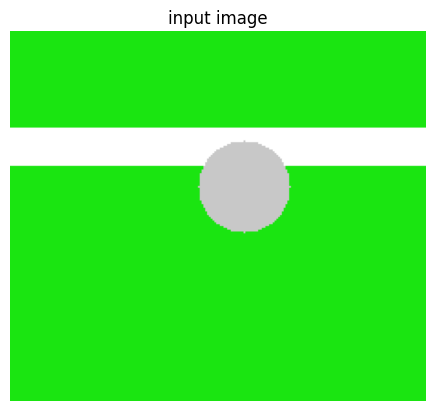

In [ ]:
random_img_index = random.randint(0, n_img)
img_path = '/content/drive/MyDrive/VISIOPE/dataset/img_'+str(random_img_index)+".png"
img = convert_bgr_to_rgb(read_image(img_path))
show_image(img, title="input image")
img_shape = img.shape
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray,100,200)

Text(0.5, 1.0, 'Edge Detector Applied')

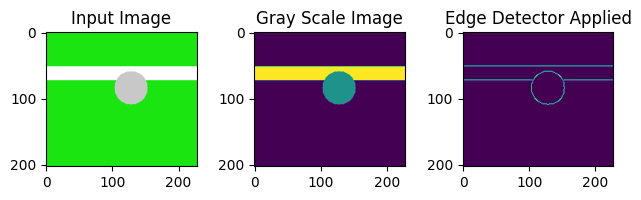

<Figure size 300x500 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(1, 3)
plt.figure(figsize=(3,5))
fig.tight_layout()
axs[0].imshow(img)
axs[0].set_title('Input Image')
axs[1].imshow(gray)
axs[1].set_title('Gray Scale Image')
axs[2].imshow(edges)
axs[2].set_title('Edge Detector Applied')

# Detection of the ball

Since the ball has a circular shape, it's used the openCV **Hough Circles** algorithm to detect the ball in the **ball_detection** function.
The function I implemented returns as first parameter a dictionary where the keys are coordinates (x and y), and the values are the 4 points (2 for the key "x" and the other 2 for the key "y") at the highest distance (radius) from the center of the circle. The second parameter returned by the ball detection function is a copy of the input image with the circle (ball) underlined.

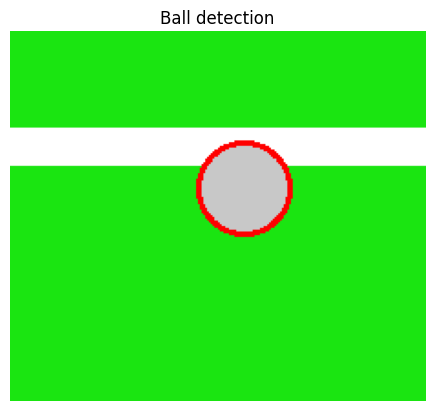

In [ ]:
points, img_ball_detected = ball_detection(img)
show_image(img_ball_detected, title="Ball detection")

# Line Detection

To detect the goal line it's used the openCV algorithm **HoughLines** in the **line_detection** function.

The goal line is made up of two lines (boundaries).

So this function returns a list of the points through which the lines pass.

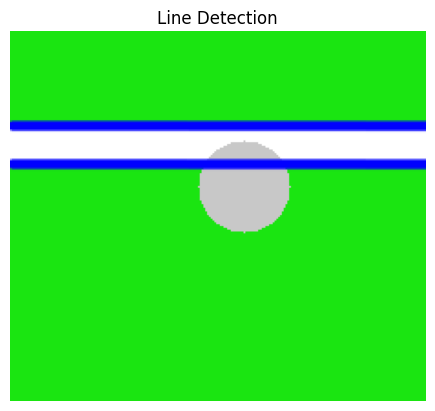

In [ ]:
goal_lines, img_line_detection = line_detection(img)
show_image(img_line_detection, title="Line Detection")

# Goal Or No Goal?

To understand if a goal is valid or not, I first check if:
- the goal line is vertical
- the goal line is horizontal


To understand if the goal line lies on a vertical or on a horizontal axis, I use the **horizontal_vertical_line** function that controls the value of the points through which the lines pass.

This function returns 0 if the line is horizontal or 1 if the line is vertical.

In [ ]:
h_or_v = horizontal_vertical_line(goal_lines, img)
if h_or_v == 0:
  print("Horizontal Line")
elif h_or_v == 1:
  print("Vertical Line")
else:
  print("No line detected...")

Horizontal Line


Once I checked this, I focus on the vertical or horizontal line projections of the ball according to the vertical or horizontal axis of the goal line.

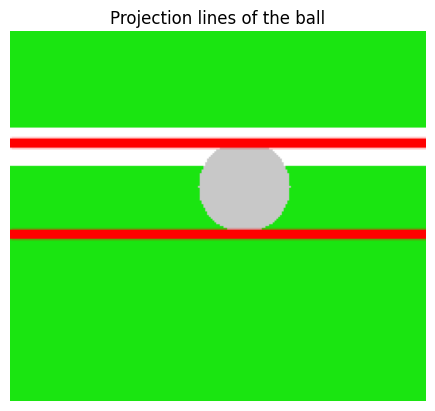

In [ ]:
ball_line, img_ball_lines = ball_lines(img, points, h_or_v)
show_image(img_ball_lines, title="Projection lines of the ball")

Now, to see if the ball has entirly passed the goal line, I describe below the mechanism I used in the **goal_no_goal** function.

*In the vertical case*, the goal is valid iff:
- the minimum ball coordinate is bigger than the maximum goal line coordinate OR the maximum ball coordinate is smaller than the minimum goal line coordinate.
(These coordinates belong to the x axis)

*In the horizontal case*, the goal is valid iff:
- the minimum ball coordinate is bigger than the maximum goal line coordinate OR the maximum ball line coordinate is smaller than the minimum goal line coordinate.
(These coordinates belong to the y axis)

In [ ]:
val = var_check(img, ball_line, goal_lines)
if val == 1:
  print("GOAL")
elif val == 0:
  print("NO GOAL")
else:
  print("Something went wrong...")

NO GOAL


# Results (CV)

Now we want to see the results on the entire dataset of the first method described above. This is done by the function **test**.



In [ ]:
# DON'T COMPILE IF YOU DON'T WANT TO LABEL AGAIN THE IMAGES (They're already labeled and stored)
test(0, training_size, src_path = "/content/drive/MyDrive/VISIOPE/dataset", dst_path = "/content/drive/MyDrive/VISIOPE/training")

Output streaming troncato alle ultime 5000 righe.
The image: /content/drive/MyDrive/VISIOPE/dataset/img_3000.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_3001.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_3002.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_3003.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_3004.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_3005.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_3006.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_3007.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_3008.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_3009.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_3010.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_3011.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE

In [ ]:
# DON'T COMPILE IF YOU DON'T WANT TO LABEL AGAIN THE IMAGES (They're already labeled and stored)
test(training_size, training_size+validation_size,
     src_path='/content/drive/MyDrive/VISIOPE/dataset', dst_path='/content/drive/MyDrive/VISIOPE/validation')

The image: /content/drive/MyDrive/VISIOPE/dataset/img_8000.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_8001.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_8002.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_8003.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_8004.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_8005.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_8006.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_8007.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_8008.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_8009.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_8010.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_8011.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_8012.png has a GOAL
The image: /content/dri

In [ ]:
# DON'T COMPILE IF YOU DON'T WANT TO LABEL AGAIN THE IMAGES (They're already labeled and stored)
test(training_size+validation_size, training_size+validation_size+test_size,
     src_path='/content/drive/MyDrive/VISIOPE/dataset', dst_path='/content/drive/MyDrive/VISIOPE/test')

The image: /content/drive/MyDrive/VISIOPE/dataset/img_9000.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_9001.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_9002.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_9003.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_9004.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_9005.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_9006.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_9007.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_9008.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_9009.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_9010.png has a NO GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_9011.png has a GOAL
The image: /content/drive/MyDrive/VISIOPE/dataset/img_9012.png has a GOAL
The image: /content/

# Deep Learning - oriented solution

The aim of this part is training a CNN on the dataset to predict if a goal is valid or not.

# Labeling the dataset

The function **test** seen above also writes in folders Goal or No_Goal for each set (training, validation and test) the images which represent a Goal or a No Goal respectively.

# Data Distribution

Training Data distribution:

Goals found:  3556
No Goals found:  4444


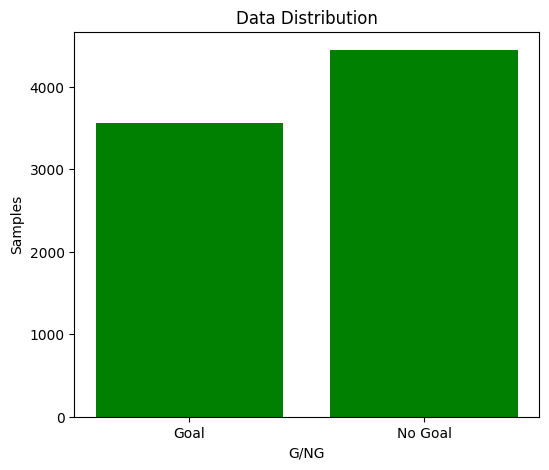

In [ ]:
goals = len(os.listdir("/content/drive/MyDrive/VISIOPE/training/Goal"))
no_goals = len(os.listdir("/content/drive/MyDrive/VISIOPE/training/No_Goal"))
print("Goals found: ", goals)
print("No Goals found: ", no_goals)
y = [goals, no_goals]
x = ['Goal', 'No Goal']
plt.figure(figsize=(6,5))
plt.bar(x, y, align="center", color="green")
plt.ylabel('Samples')
plt.xlabel('G/NG')
plt.title('Data Distribution')
plt.show()

Validation Data Distribution:

Validation distribution data.
Goals: 440
No Goals: 560


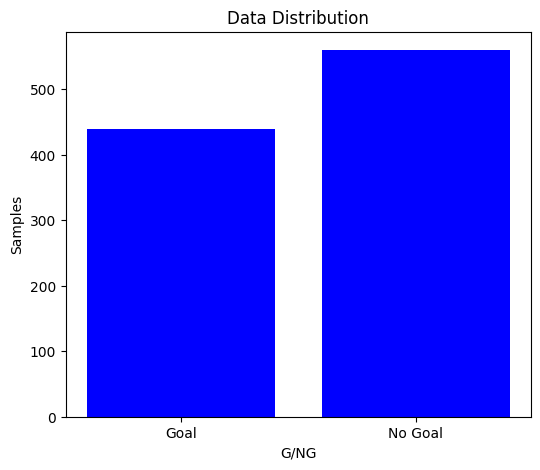

In [ ]:
goals = len(os.listdir("/content/drive/MyDrive/VISIOPE/validation/Goal"))
no_goals = len(os.listdir("/content/drive/MyDrive/VISIOPE/validation/No_Goal"))
print("Validation distribution data.\nGoals: "+str(goals)+"\nNo Goals: "+str(no_goals))
y = [goals, no_goals]
x = ['Goal', 'No Goal']
plt.figure(figsize=(6,5))
plt.bar(x, y, align="center", color="blue")
plt.ylabel('Samples')
plt.xlabel('G/NG')
plt.title('Data Distribution')
plt.show()

**Test Data Distribution**:

Test distribution data.
Goals: 399
No Goals: 601


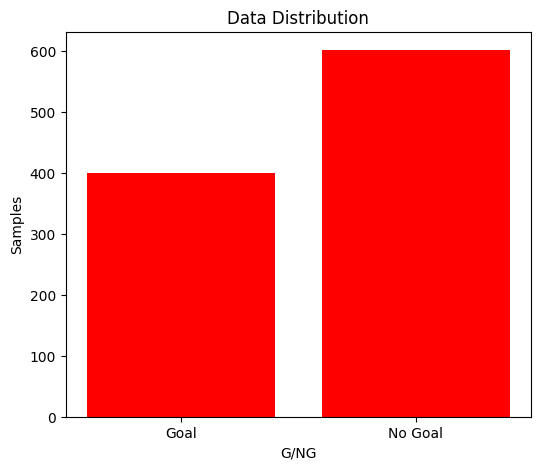

In [ ]:
goals = len(os.listdir("/content/drive/MyDrive/VISIOPE/test/Goal"))
no_goals = len(os.listdir("/content/drive/MyDrive/VISIOPE/test/No_Goal"))
print("Test distribution data.\nGoals: "+str(goals)+"\nNo Goals: "+str(no_goals))
y = [goals, no_goals]
x = ['Goal', 'No Goal']
plt.figure(figsize=(6,5))
plt.bar(x, y, align="center", color="red")
plt.ylabel('Samples')
plt.xlabel('G/NG')
plt.title('Data Distribution')
plt.show()

# CNN initizialization

With the **ImageDataGenerator** function we define the train and validation generator which allows us to:

1) Read images from the disk.

2) Decode contents of these images and convert it into proper grid format as per their RGB content.

3) Convert them into floating point tensors.

4) Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

In [ ]:
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale=1/255)

Now, we can import from the right directory the data with **flow_from_directory** function. It also sets the batch_size and class_mode.
For the training set we use a batch_size of 256 while for the validation set we use a batch_size of 64. Both of them has as class_mode the attribute binary, because the result of the cnn work is a binary classification: Goal, No Goal.

In [ ]:
training_set = train.flow_from_directory('/content/drive/MyDrive/VISIOPE/training/',
                                         target_size= (200,200),
                                         batch_size = 256,
                                         class_mode = 'binary')

validation_set = train.flow_from_directory('/content/drive/MyDrive/VISIOPE/validation/',
                                         target_size= (200,200),
                                         batch_size = 64,
                                         class_mode = 'binary')

Labels:


*   Goal: 0
*   No_Goal: 1



In [ ]:
training_set.class_indices

{'Goal': 0, 'No_Goal': 1}

# CNN structure

Below the structure of the CNN is shown. It has:


*   **3 Convolutional Layers:** the filter is a 5x5 matrix and 16, 32 and 64 as dimensionality of the output space according to the first, second and third layer. Each convolutional operation is followed by an activation function (relu)
*   **3 MaxPooling Layers**: they follow each convolutional layer and help in reducing the spatial dimensions. It's used a 2x2 matrix to store the max pool operation
*   The **Flatten Layer** converts the multi-dimensional image data array to 1D array
*   **2 Dense Layers**: the first one has 512 as units value, it means that 512 is the output dimensionality and uses relu as activation function; the second one has 1 as units value, it means that it produces a single output which represents the predicted label. Since this is a binary classification task the sigmoid function is used as activation.

In [ ]:
model = tf.keras.models.Sequential( [tf.keras.layers.Conv2D(16, (5,5), activation = 'relu', input_shape = (200,200,3)),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    #
                                    tf.keras.layers.Conv2D(32, (5,5), activation='relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    #
                                    tf.keras.layers.Conv2D(64, (5,5), activation ='relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    #
                                    tf.keras.layers.Flatten(),
                                    #
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    #
                                    tf.keras.layers.Dense(1, activation='sigmoid')
                                    ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 21, 21, 64)       0

It's used as loss the binary cross entropy loss and Adam as optimizer. Learning rate is set to 0.001.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics='accuracy')

To avoid inefficient computation time and space we use the Early Stopping method which stops the model process if the validation accuracy (in this case) doesn't decrement its value for n times and once it's stopped it restores the best weights.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Results (DL)

In [ ]:
model_fit = model.fit(training_set,
                      steps_per_epoch = 3,
                      epochs = 30,
                      callbacks=[callback],
                      validation_data = validation_set)

Epoch 1/30
3/3 [==============================] - 473s 188s/step - loss: 2.0186 - accuracy: 0.4505 - val_loss: 0.7939 - val_accuracy: 0.4400
Epoch 2/30
3/3 [==============================] - 211s 70s/step - loss: 0.7159 - accuracy: 0.4922 - val_loss: 0.7016 - val_accuracy: 0.5600
Epoch 3/30
3/3 [==============================] - 200s 68s/step - loss: 0.6958 - accuracy: 0.5482 - val_loss: 0.7014 - val_accuracy: 0.4790
Epoch 4/30
3/3 [==============================] - 184s 59s/step - loss: 0.6861 - accuracy: 0.5456 - val_loss: 0.6696 - val_accuracy: 0.6100
Epoch 5/30
3/3 [==============================] - 165s 55s/step - loss: 0.6587 - accuracy: 0.6406 - val_loss: 0.6600 - val_accuracy: 0.5970
Epoch 6/30
3/3 [==============================] - 153s 50s/step - loss: 0.6642 - accuracy: 0.6003 - val_loss: 0.6695 - val_accuracy: 0.6100
Epoch 7/30
3/3 [==============================] - 115s 34s/step - loss: 0.6507 - accuracy: 0.6198 - val_loss: 0.6365 - val_accuracy: 0.6180
Epoch 8/30
3/3 [===

In [ ]:
def network_test():

  goal_path = "/content/drive/MyDrive/VISIOPE/test/Goal"
  no_goal_path = "/content/drive/MyDrive/VISIOPE/test/No_Goal"

  img_goal = os.listdir("/content/drive/MyDrive/VISIOPE/test/Goal")
  img_no_goal = os.listdir("/content/drive/MyDrive/VISIOPE/test/No_Goal")

  dim_goal = len(img_goal)
  dim_no_goal = len(img_no_goal)

  TP = 0
  TN = 0
  FP = 0
  FN = 0

  for i in os.listdir(goal_path):
    img = image.load_img(goal_path+"/"+str(i), target_size=(200,200,3))
    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    val = model.predict(images)
    if val == 0:
      TP+=1
    else:
      FP+=1

  for i in os.listdir(no_goal_path):
    img = image.load_img(no_goal_path+"/"+str(i), target_size=(200,200,3))
    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    val = model.predict(images)
    if val == 0:
      FN += 1
    else:
      TN += 1

  correct = TP+TN
  total_dim = dim_goal+dim_no_goal

  test_acc = correct/total_dim

  return test_acc, TP, TN, FP, FN

In [ ]:
acc, TP, TN, FP, FN = network_test()

1/1 [==============================] - 0s 78ms/step


Defining as:


*   TP (true positive): Goals correctly classified as Goals
*   TN (true negative): No Goals correctly classified as No Goals
*   FP (false positive): No Goals wrongly classified as Goals
*   FN (false negative): Goals wrongly classified as No Goals

Let's print a bar with these values:

Test accuracy:  0.926


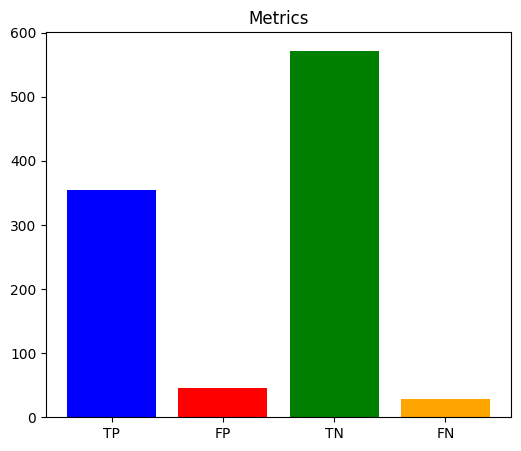

In [ ]:
print("Test accuracy: ", acc)
y = [TP, FP, TN, FN]
x = ['TP', 'FP', 'TN', 'FN']
plt.figure(figsize=(6,5))
plt.bar(x, y, align="center", color=["blue", "red", "green", "orange"])
plt.title('Metrics')
plt.show()

In [ ]:
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1_score = 2*(precision*recall)/(precision+recall)
print("PRECISION: ", precision)
print("RECALL: ", recall)
print("F1-SCORE: ", f1_score)

PRECISION:  0.8872180451127819
RECALL:  0.9242819843342036
F1-SCORE:  0.9053708439897699


# Regularization Techniques

# Data Augmentation

In order to:

*  increase the model's ability to generalize
*  add variability to the data and minimize data overfitting
*  save on the cost of collecting and labeling additional data
*  improve the accuracy of the deep learning model's predictions

the data augmentation technique is used.


To balance the training set, divided in 3556 Goals images and 4444 No Goals images, we increase the number of images representing Goals. Also, this procedure would decrease the number of False Positive which is higher than False Negatives.
By analyzing the metrics (precision and recall) all discussed above makes sense.


In [ ]:
def augment_data(training_path):

  goals_img = training_path+str("/Goal")
  no_goals_img = training_path+str("/No_Goal")
  goal_size = len(os.listdir(goals_img))
  no_goal_size = len(os.listdir(no_goals_img))
  diff = abs(goal_size-no_goal_size)
  dim = goal_size+no_goal_size

  if goal_size > no_goal_size:
    dest_path = no_goals_img
    src_img = os.listdir(no_goals_img)[random.randint(0, no_goal_size)]
    img = load_img(dest_path+"/"+src_img)
  else:
    dest_path = goals_img
    src_img = os.listdir(goals_img)[random.randint(0, goal_size)]
    img = load_img(dest_path+"/"+src_img)

  imageDataGen = ImageDataGenerator(brightness_range=[0.5,1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    fill_mode='nearest')


  dataImage = img_to_array(img)
  imageNew = expand_dims(dataImage, 0)
  iterator = imageDataGen.flow(imageNew, batch_size=1)

  for i in range(0, diff):
    batch = iterator.next()
    image = batch[0].astype('uint8')
    name = "/img_"+str(dim+i)+".png"
    cv.imwrite(dest_path+name, image)

  return

In [ ]:
augment_data(training_path)

Goals found:  4444
No Goals found:  4444


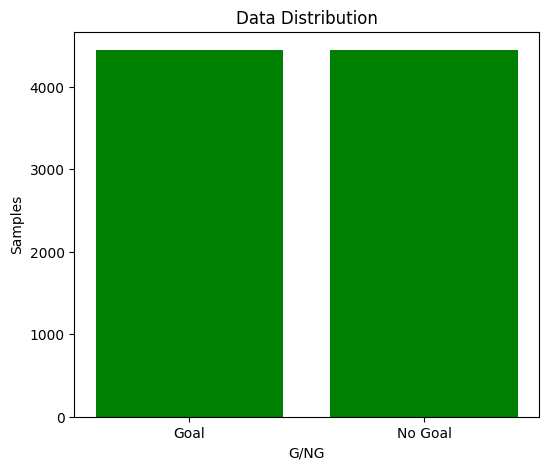

In [ ]:
goals = len(os.listdir("/content/drive/MyDrive/VISIOPE/training/Goal"))
no_goals = len(os.listdir("/content/drive/MyDrive/VISIOPE/training/No_Goal"))
print("Goals found: ", goals)
print("No Goals found: ", no_goals)
y = [goals, no_goals]
x = ['Goal', 'No Goal']
plt.figure(figsize=(6,5))
plt.bar(x, y, align="center", color="green")
plt.ylabel('Samples')
plt.xlabel('G/NG')
plt.title('Data Distribution')
plt.show()

Now, as we can see in the histogram above, we have:

**number of goal images = number of no goal images**

# Results after augmentation

In [ ]:
model_fit = model.fit(training_set,
                      steps_per_epoch = 3,
                      epochs = 30,
                      callbacks=[callback],
                      validation_data = validation_set)

Epoch 1/30
3/3 [==============================] - 315s 132s/step - loss: 3.5022 - accuracy: 0.4961 - val_loss: 1.1730 - val_accuracy: 0.4400
Epoch 2/30
3/3 [==============================] - 117s 35s/step - loss: 0.8502 - accuracy: 0.5000 - val_loss: 0.6974 - val_accuracy: 0.4400
Epoch 3/30
3/3 [==============================] - 129s 42s/step - loss: 0.6957 - accuracy: 0.4635 - val_loss: 0.7010 - val_accuracy: 0.4400
Epoch 4/30
3/3 [==============================] - 126s 43s/step - loss: 0.6852 - accuracy: 0.5733 - val_loss: 0.7109 - val_accuracy: 0.4430
Epoch 5/30
3/3 [==============================] - 126s 43s/step - loss: 0.6880 - accuracy: 0.5117 - val_loss: 0.6640 - val_accuracy: 0.6370
Epoch 6/30
3/3 [==============================] - 125s 43s/step - loss: 0.6550 - accuracy: 0.6263 - val_loss: 0.6855 - val_accuracy: 0.5220
Epoch 7/30
3/3 [==============================] - 121s 43s/step - loss: 0.6759 - accuracy: 0.5677 - val_loss: 0.6406 - val_accuracy: 0.6440
Epoch 8/30
3/3 [===

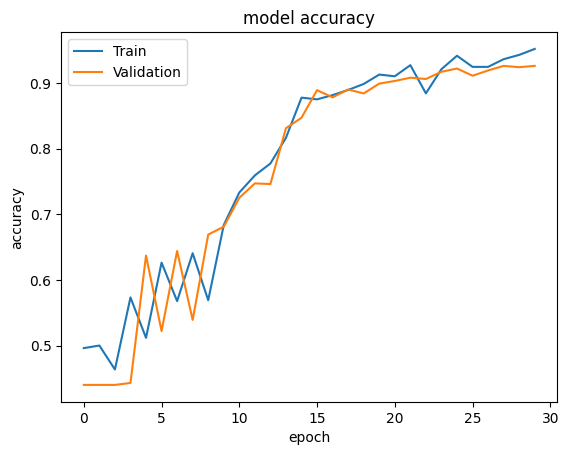

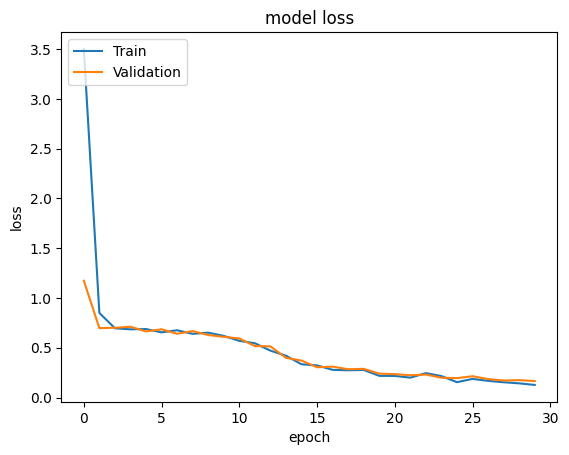

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
acc, TP, TN, FP, FN = network_test()

1/1 [==============================] - 0s 50ms/step


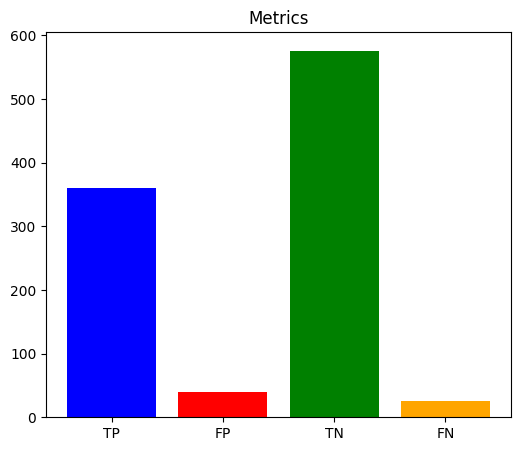

In [ ]:
y = [TP, FP, TN, FN]
x = ['TP', 'FP', 'TN', 'FN']
plt.figure(figsize=(6,5))
plt.bar(x, y, align="center", color=["blue", "red", "green", "orange"])
plt.title('Metrics')
plt.show()

In [ ]:
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1_score = 2*(precision*recall)/(precision+recall)
print("ACCURACY: ", round(acc,3))
print("PRECISION: ", round(precision,3))
print("RECALL: ", round(recall,3))
print("F1-SCORE: ", round(f1_score,3))

ACCURACY:  0.936
PRECISION:  0.902
RECALL:  0.935
F1-SCORE:  0.918


As the results show, the FP number is decreased and accuracy has increased.

# Drop Out

Dropout works by randomly "dropping out" a fraction of the neurons or units in a neural network during training. This means that during each training iteration, a random subset of neurons is temporarily ignored or "turned off."
In this case Drop Out rate is 0.5 and it is applied after the Dense Layer.

Also, by forcing the network to learn from a subset of neurons at each iteration, dropout promotes the learning of more diverse and independent features, improving the network's ability to generalize to new, unseen data.

In [ ]:
model = tf.keras.models.Sequential( [tf.keras.layers.Conv2D(16, (5,5), activation = 'relu', input_shape = (200,200,3)),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    #
                                    tf.keras.layers.Conv2D(32, (5,5), activation='relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    #
                                    tf.keras.layers.Conv2D(64, (5,5), activation ='relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    #
                                    tf.keras.layers.Flatten(),
                                    #
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    #
                                    tf.keras.layers.Dropout(0.5),
                                    #
                                    tf.keras.layers.Dense(1, activation='sigmoid')
                                    ])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics='accuracy')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Final Results

In [ ]:
model_fit = model.fit(training_set,
                      steps_per_epoch = 3,
                      epochs = 50,
                      callbacks=[callback],
                      validation_data = validation_set)

Epoch 1/50
3/3 [==============================] - 8s 2s/step - loss: 1.0726 - accuracy: 0.5286 - val_loss: 0.7488 - val_accuracy: 0.5600
Epoch 2/50
3/3 [==============================] - 5s 2s/step - loss: 0.7279 - accuracy: 0.4987 - val_loss: 0.6921 - val_accuracy: 0.5090
Epoch 3/50
3/3 [==============================] - 5s 2s/step - loss: 0.6828 - accuracy: 0.5599 - val_loss: 0.6899 - val_accuracy: 0.5250
Epoch 4/50
3/3 [==============================] - 8s 4s/step - loss: 0.6584 - accuracy: 0.6016 - val_loss: 0.6606 - val_accuracy: 0.5860
Epoch 5/50
3/3 [==============================] - 5s 2s/step - loss: 0.6416 - accuracy: 0.6055 - val_loss: 0.6550 - val_accuracy: 0.5900
Epoch 6/50
3/3 [==============================] - 8s 3s/step - loss: 0.6303 - accuracy: 0.6458 - val_loss: 0.6309 - val_accuracy: 0.6490
Epoch 7/50
3/3 [==============================] - 5s 2s/step - loss: 0.5992 - accuracy: 0.6680 - val_loss: 0.5792 - val_accuracy: 0.7090
Epoch 8/50
3/3 [=========================

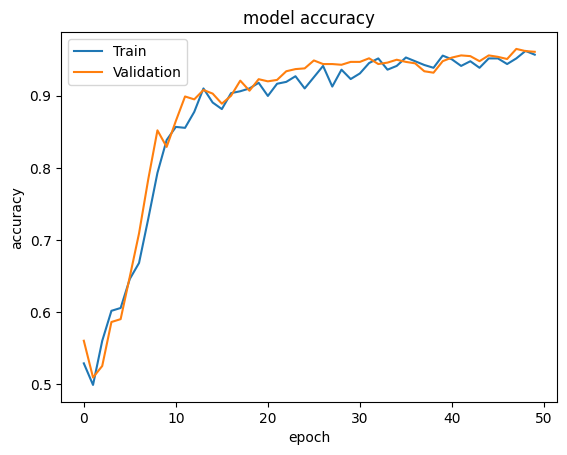

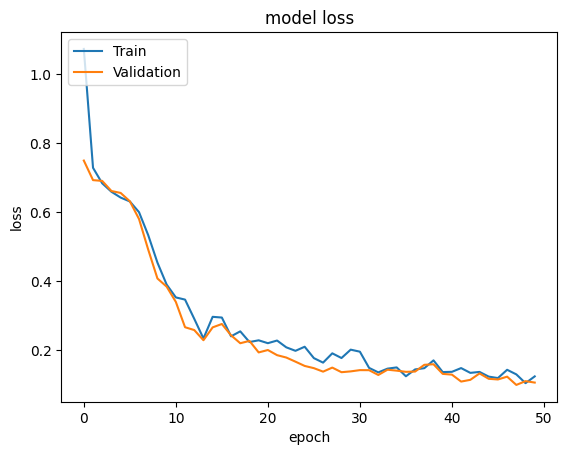

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
acc, TP, TN, FP, FN = network_test()

1/1 [==============================] - 0s 18ms/step


Test accuracy:  0.958


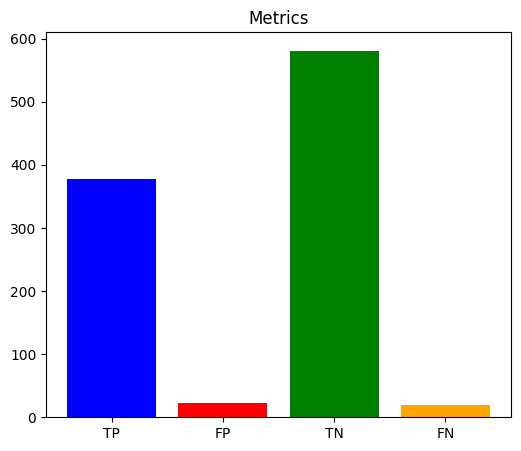

In [ ]:
print("Test accuracy: ", acc)
y = [TP, FP, TN, FN]
x = ['TP', 'FP', 'TN', 'FN']
plt.figure(figsize=(6,5))
plt.bar(x, y, align="center", color=["blue", "red", "green", "orange"])
plt.title('Metrics')
plt.show()

In [ ]:
precision = TP/(TP + FP)
recall = TP/(TP + FN)
f1_score = 2*(precision*recall)/(precision+recall)
print("ACCURACY: ", round(acc,3))
print("PRECISION: ", round(precision,3))
print("RECALL: ", round(recall,3))
print("F1-SCORE: ", round(f1_score,3))

ACCURACY:  0.958
PRECISION:  0.945
RECALL:  0.95
F1-SCORE:  0.947


In [ ]:
print("TP: ", TP)
print("FP: ", FP)
print("TN: ", TN)
print("FN: ", FN)

TP:  377
FP:  22
TN:  581
FN:  20


# Conclusion

After all this work, we finally have reached our goal.
The results are pretty good; considering the low starting dimensions of the dataset.

Of course, since we've generated the dataset without noise or disturb or bad quality we have had an easier job in finding better solutions.

However, the generated images are similar to the ones provided by the so called "hawk eye", the system which segments the real world frames captured by the cameras.

So we should deal with another task: segmenting real images and then applying the procedure seen above!

But for this time, we end here.